#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16

**CH16A Predicting apartment prices with random forest and gradient boosintg machines**

using the airbnb dataset

version 1.1 2023-02-01

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
# from mizani.formatters import percent_format
# from plotnine import *
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

## PART I
### Loading and preparing data 
----------------------------------------------

In [2]:
url = 'https://raw.githubusercontent.com/peterduronelly/DA3-Coding-Examples/main/data/airbnb_london_workfile_adj_book.csv'
data = pd.read_csv(url)

In [3]:
data.shape

(51646, 92)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51646 entries, 0 to 51645
Data columns (total 92 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   f_property_type            51646 non-null  object 
 1   f_room_type                51646 non-null  object 
 2   f_room_type2               51646 non-null  object 
 3   f_cancellation_policy      51646 non-null  object 
 4   f_bed_type                 51646 non-null  object 
 5   f_neighbourhood_cleansed   51646 non-null  object 
 6   usd_price_day              51646 non-null  int64  
 7   n_accommodates             51646 non-null  int64  
 8   n_bathrooms                51646 non-null  float64
 9   n_review_scores_rating     51646 non-null  int64  
 10  n_number_of_reviews        51646 non-null  int64  
 11  n_guests_included          51646 non-null  int64  
 12  n_reviews_per_month        51646 non-null  float64
 13  n_extra_people             51646 non-null  int

In [5]:
data.isna().sum().sum()

0

#### EDA, sample definition and preparation

In [6]:
# We focus on normal apartments, n<8
data = data[data.n_accommodates < 8]

In [7]:
data.shape

(49826, 92)

In [8]:
# copy a variable - purpose later, see at variable importance
data['n_accommodates_copy'] = data['n_accommodates']

***numerical variables***

In [9]:
# too long to display and read
data.describe().T

,count,mean,std,min,25%,50%,75%,max
usd_price_day,49826.0,8.898404e+01,7.051509e+01,8.000000,4.100000e+01,7.000000e+01,1.100000e+02,9.990000e+02
n_accommodates,49826.0,2.838759e+00,1.494748e+00,1.000000,2.000000e+00,2.000000e+00,4.000000e+00,7.000000e+00
n_bathrooms,49826.0,1.224260e+00,4.664481e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
n_review_scores_rating,49826.0,9.245862e+01,8.418474e+00,20.000000,9.200000e+01,9.400000e+01,9.700000e+01,1.000000e+02
n_number_of_reviews,49826.0,1.234014e+01,2.588993e+01,0.000000,0.000000e+00,3.000000e+00,1.200000e+01,3.960000e+02
...,...,...,...,...,...,...,...,...
ln_days_since3,49826.0,1.996072e+02,8.026405e+01,0.000000,1.604325e+02,1.944078e+02,2.411713e+02,4.948179e+02
n_days_since2,49826.0,2.931985e+05,5.640361e+05,0.000000,5.198400e+04,1.069290e+05,2.540160e+05,7.409284e+06
n_days_since3,49826.0,3.046539e+08,9.636140e+08,0.000000,1.185235e+07,3.496578e+07,1.280241e+08,2.016807e+10
ln_review_scores_rating,49826.0,4.520910e+00,1.204214e-01,2.995732,4.521789e+00,4.543295e+00,4.574711e+00,4.605170e+00


In [10]:
data.price.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).map('{:,.1f}'.format)

count    49,826.0
mean         89.0
std          70.5
min           8.0
1%           20.0
10%          30.0
25%          41.0
50%          70.0
75%         110.0
90%         169.0
99%         350.0
max         999.0
Name: price, dtype: object

***categorical variables***

In [11]:
data.f_room_type.value_counts()

Entire home/apt    24938
Private room       24351
Shared room          537
Name: f_room_type, dtype: int64

In [12]:
data.f_property_type.value_counts()

Apartment    37467
House        12359
Name: f_property_type, dtype: int64

In [13]:
data.f_number_of_reviews.value_counts()

2    31575
1    15148
3     3103
Name: f_number_of_reviews, dtype: int64

***split train and test***
- train is where we do it all, incl CV

- first pick a smaller than usual training set so that models run faster and check if works
- if works, start anew without these two lines

In [14]:
data_train, data_holdout = train_test_split( data, train_size=0.7, random_state=42)

In [15]:
data_train.shape, data_holdout.shape

((34878, 93), (14948, 93))

In [16]:
# basic variables inc neighbourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_cancellation_policy",
    "f_bed_type",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_familykidfriendly",
    "d_airconditioning:f_property_type",
    "d_cats:f_property_type",
    "d_dogs:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [17]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

## PART II
### RANDOM FORESTS 
-------------------------------------------------------

For data preparation we are using the [patsy](https://patsy.readthedocs.io/en/latest/overview.html) package (not [this](https://en.wikipedia.org/wiki/Patsy_%28Monty_Python%29) Patsy, bur almost). `patsy` is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices. It is closely inspired by and compatible with the formula mini-language used in R and S.

In [18]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

`dmatrices()` constructs two design matrices given a formula_like and data. By convention, the first matrix is the “outcome” or “y” data, and the second is the “predictor” or “x” data.

What is X?

In [19]:
type(X)

patsy.design_info.DesignMatrix

In [20]:
X

DesignMatrix with shape (34878, 97)
  Columns:
    ['Intercept',
     'f_property_type[T.House]',
     'f_room_type[T.Private room]',
     'f_room_type[T.Shared room]',
     'f_cancellation_policy[T.moderate]',
     'f_cancellation_policy[T.strict]',
     'f_bed_type[T.Real Bed]',
     'f_neighbourhood_cleansed[T.Barnet]',
     'f_neighbourhood_cleansed[T.Bexley]',
     'f_neighbourhood_cleansed[T.Brent]',
     'f_neighbourhood_cleansed[T.Bromley]',
     'f_neighbourhood_cleansed[T.Camden]',
     'f_neighbourhood_cleansed[T.City of London]',
     'f_neighbourhood_cleansed[T.Croydon]',
     'f_neighbourhood_cleansed[T.Ealing]',
     'f_neighbourhood_cleansed[T.Enfield]',
     'f_neighbourhood_cleansed[T.Greenwich]',
     'f_neighbourhood_cleansed[T.Hackney]',
     'f_neighbourhood_cleansed[T.Hammersmith and Fulham]',
     'f_neighbourhood_cleansed[T.Haringey]',
     'f_neighbourhood_cleansed[T.Harrow]',
     'f_neighbourhood_cleansed[T.Havering]',
     'f_neighbourhood_cleansed[T.Hillin

In [21]:
np.asarray(X)

array([[1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [22]:
import math

In [23]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 9.85.


In [24]:
X.shape

(34878, 97)

In [25]:
type(y)

patsy.design_info.DesignMatrix

In [26]:
# a two-dimensional object
y.shape

(34878, 1)

In [27]:
# using ravel() we flatten it to a one-dimensional data object. 
y.ravel().shape

(34878,)

In [28]:
rfr = RandomForestRegressor(random_state = 42)

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [29]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [30]:
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

`GridsearchCV()` is an exhaustive search over specified parameter values for an estimator.

In [31]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .............max_features=6, min_samples_leaf=5; total time=   2.1s
[CV 2/5] END .............max_features=6, min_samples_leaf=5; total time=   2.0s
[CV 3/5] END .............max_features=6, min_samples_leaf=5; total time=   2.0s
[CV 4/5] END .............max_features=6, min_samples_leaf=5; total time=   2.0s
[CV 5/5] END .............max_features=6, min_samples_leaf=5; total time=   2.0s
[CV 1/5] END ............max_features=6, min_samples_leaf=10; total time=   1.7s
[CV 2/5] END ............max_features=6, min_samples_leaf=10; total time=   1.7s
[CV 3/5] END ............max_features=6, min_samples_leaf=10; total time=   1.7s
[CV 4/5] END ............max_features=6, min_samples_leaf=10; total time=   1.7s
[CV 5/5] END ............max_features=6, min_samples_leaf=10; total time=   1.7s
[CV 1/5] END ............max_features=6, min_samples_leaf=15; total time=   1.6s
[CV 2/5] END ............max_features=6, min_sam

<br>

Cross-validated results are saved in the grid search object's `cv_results_` attribute. Note that *RMSE* is displayed as a negative number. 

In [32]:
rf_model.cv_results_

{'mean_fit_time': array([1.90825534, 1.64267068, 1.55470901, 2.44246593, 2.06832156,
        2.03393326, 2.65544758, 2.89682837, 3.04799991, 3.28179646,
        2.80481453, 2.78350353]),
 'std_fit_time': array([0.06024001, 0.01258657, 0.04557351, 0.21769515, 0.01472828,
        0.07324288, 0.03217807, 0.67129351, 0.59672245, 0.12405862,
        0.11198352, 0.1319228 ]),
 'mean_score_time': array([0.09920039, 0.08289113, 0.07548275, 0.10518541, 0.08914542,
        0.10160546, 0.10506878, 0.08975301, 0.14221797, 0.10788798,
        0.09511323, 0.09127016]),
 'std_score_time': array([0.0010681 , 0.00049418, 0.0003713 , 0.00224098, 0.00057631,
        0.0393161 , 0.00093119, 0.00247956, 0.0625234 , 0.00109043,
        0.009647  , 0.00968146]),
 'param_max_features': masked_array(data=[6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dty

In [33]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [34]:
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [35]:
df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-46.353901
1,6,10,-47.296008
2,6,15,-47.952748
3,8,5,-45.478749
4,8,10,-46.441218
5,8,15,-46.915945
6,10,5,-45.073783
7,10,10,-45.858312
8,10,15,-46.380642
9,12,5,-44.778546


In [36]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,46.35,47.30,47.95
8,45.48,46.44,46.92
10,45.07,45.86,46.38
12,44.78,45.45,45.90


In [37]:
rf_model.best_score_

-44.77854560414037

In [38]:
rf_model.best_params_

{'max_features': 12, 'min_samples_leaf': 5}

In [39]:
rf_model.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5, random_state=42)

## PART III
### MODEL DIAGNOSTICS 
---

#### feature importances

***individual***

In [40]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [41]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,f_room_type[T.Private room],19.6%,19.6%
1,n_accommodates,19.5%,39.0%
2,n_beds,11.9%,51.0%
3,f_bathroom,10.7%,61.7%
4,f_neighbourhood_cleansed[T.Westminster],3.4%,65.1%
5,f_neighbourhood_cleansed[T.Kensington and Chelsea],3.0%,68.2%
6,d_tv,2.7%,70.8%
7,d_familykidfriendly,1.9%,72.8%
8,n_number_of_reviews,1.8%,74.6%
9,d_dryer,1.7%,76.3%


<br> 

Plotting var imp per se results in a nasty chart.

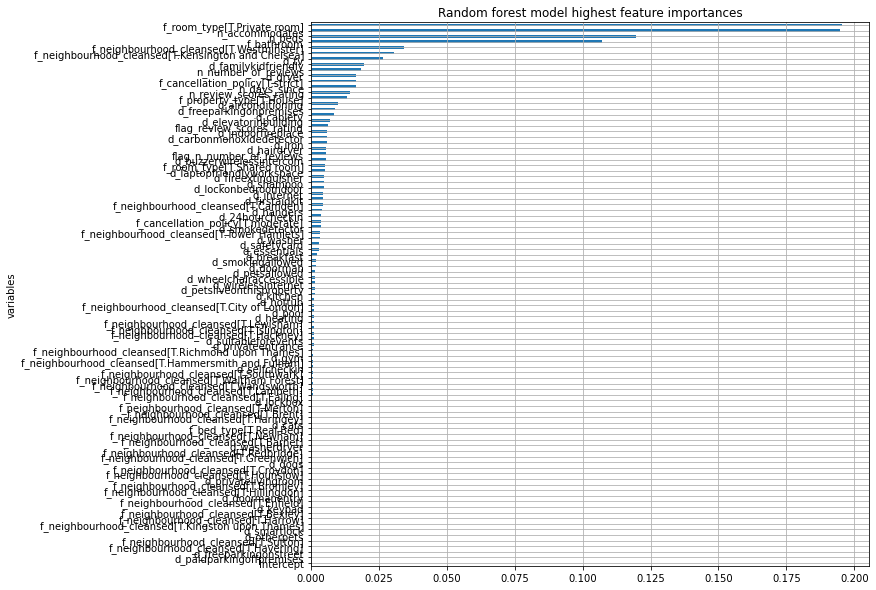

In [42]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [43]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

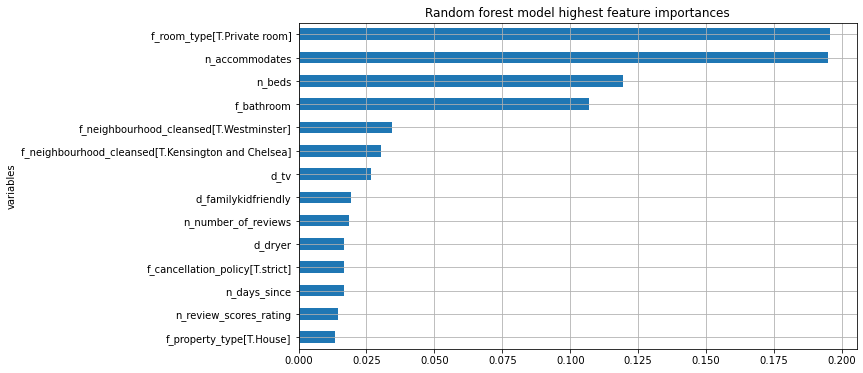

In [44]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

***grouped variable importance - keep binaries created off factors together***

For this, you need to create an `sklearn` Pipeline inclduing `OneHotEncoding` (before, encoding was done by patsy's `dmatrices`). This way permutation_importance can calculate factor variables' importance 

In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [ ]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [ ]:
rf.fit(data_train[predictors_2],data_train.price)

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [ ]:
%%time
result = permutation_importance(
    rf,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

In [ ]:
result

In [ ]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

In [ ]:
grouped = [
    "f_bed_type",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed",
    "f_cancellation_policy",
]

In [ ]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [ ]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

In [ ]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [ ]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

In [ ]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

## Partial Dependence Plots 
-------------------------------------------------------


In [ ]:
# Note: easy way, sklearn has plot_partial_dependence function we do this on holdout set!
# Also, note that we run it not on the rf_model but on the rf pipeline to manage OneHot_Encoding on the fly.

plot_partial_dependence(
    rf,
    data_holdout[predictors_2],
    ["n_accommodates"],
    feature_names=data_holdout[predictors_2].columns,
    line_kw={"marker": "o", "color": 'k'},
)

plt.grid()
plt.ylim(70, 130)
plt.show()

We can do our pdp plots using Pandas built-in plot method.

In [ ]:
accomodates_pdp = partial_dependence(
    rf, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)

In [ ]:
accomodates_pdp

In [ ]:
# We need to access the elements of this complex data structure
type(accomodates_pdp)

In [ ]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

In [ ]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: number of accomodates'
);

In [ ]:
roomtype_pdp = partial_dependence(
    rf, data_holdout[predictors_2], ["f_room_type"], kind="average"
)

In [ ]:
pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: room type'
);

### Subsample performance: RMSE / mean(y) 
---------------------------------------
NOTE  we do this on the holdout set, using the encoding pipeline `rf` again.


In [ ]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf.predict(data_holdout[predictors_2])
)

***Creating tables of heterogeneity by various grouping factors***
- apartman size

This is how we start:

In [ ]:
data_holdout_w_prediction['is_low_size'] = data_holdout_w_prediction.n_accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

In [ ]:
data_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

Putting it in a function with additional columns

In [ ]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [ ]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [ ]:
accom_subset

- fancy neighborhoods

In [ ]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        [
            "Westminster",
            "Camden",
            "Kensington and Chelsea",
            "Tower Hamlets",
            "Hackney",
            "Newham",
        ]
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

neightbourhood_subset

- property type

In [ ]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Apartment", "House"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)

proptype_subset

In [ ]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout

In [ ]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough", "------"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("------")

In [ ]:
type_rows

### Performance across subsamples

In [ ]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        type_rows.iloc[[3]],
        all_holdout,
    ]
)

## PART IV
### HORSERACE: compare with other models 
-----------------------------------------------
**NOTE: this part of the code is not finished**

1. ***OLS with dummies for area***

 using model B

In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

In [ ]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [ ]:
ols_model_coeffs_df

2.  LASSO

using extended model w interactions

In [ ]:
from sklearn.linear_model import ElasticNet

The parameter `l1_ratio7` corresponds to *alpha* in the `glmnet` R package while `alpha` corresponds to the *lambda* parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [ ]:
lasso_model =  ElasticNet(l1_ratio = 1,normalize=True,fit_intercept=True)

In [ ]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [ ]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [ ]:
%%time
lasso_model_cv.fit(X, y.ravel())

In [ ]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

In [ ]:
lasso_model_cv.best_estimator_

In [ ]:
lasso_model_cv.cv_results_

In [ ]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

3. ***CART model***

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [ ]:
cart_model = DecisionTreeRegressor(random_state=2023)

Get potential ccp_alpha parameters

In [ ]:
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
ccp_alphas

In [ ]:
ccp_alphas.shape

Apply random search to select a "best" alpha, default is 10 iterations
`RandomizedSearchCV` does not calculate all potential alphas, just a random 10-element subset of the many potential alphas

In [ ]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
cart_model_cv.fit(X,y.ravel())

In [ ]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

4. GBM

**NOTE:** With complex grid search run for a **very long time**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10, n_estimators = 50)

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [ ]:
%%time
gbm_pipe.fit(data_train[predictors_2],data_train.price)

In [ ]:
gbm_model_cv.cv_results_

In [ ]:
gbm_model_cv.best_estimator_

In [ ]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [ ]:
gbm_rmse

Comparing model results on CV RMSE.

In [ ]:
pd.DataFrame({'model': ['OLS', 'LASSO', 'CART', 'random forest', 'GBM'],
              'CV RMSE': [ols_rmse, lasso_rmse, cart_rmse, all_holdout.rmse[0], gbm_rmse]})

***GBM with complex tuning parameter set: takes forever to run***

Histogram-based Gradient Boosting Regression Tree. It is experimental so we need to enable experimental features first. This implementation is inspired by [LightGBM](https://github.com/Microsoft/LightGBM).

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
gbm_broad = HistGradientBoostingRegressor()

In [ ]:
tune_grid = {
    "max_iter": [50, 100, 200],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.1, 0.15, 0.2],
    "min_samples_leaf": [5, 10, 20, 30],
}

gbm_model_cv_broad = GridSearchCV(
    gbm_broad,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
)

In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_broad = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv_broad)], verbose=True
)

In [ ]:
%%time
gbm_pipe_broad.fit(data_train[predictors_2],data_train.price)

In [ ]:
print('Broad GBM RMSE is: {:.4f}.'.format(gbm_model_cv_broad.best_score_*-1))
print('Simple GBM RMSE is: {:.4f}.'.format(gbm_model_cv.best_score_*-1))